In [49]:
pip install matplotlib scikit-learn datashader dask[dataframe] colorcet holoviews

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 50.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 73.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 10.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf

In [3]:
def plot_it(points, labels):
    background = 'black'
    height=2048
    width=2048
    alpha=1
    colors=labels
    dpi = plt.rcParams["figure.dpi"]
    point_size = 100.0 / np.sqrt(points.shape[0])
    fig = plt.figure(figsize=(width / dpi, height / dpi))
    ax = fig.add_subplot(111)
    ax.set(xticks=[], yticks=[])
    ax.set_facecolor(background)
    ax.scatter(points[:, 0], points[:, 1], s=point_size, c=colors, alpha=alpha)
    ax.text(0.99,
            0.01, 
            "UMAP: n_neighbors={}, min_dist={}".format(5, 0),
            transform=ax.transAxes,
            horizontalalignment="right",
            color='white',
    )
    return ax



In [4]:
def _extent(points): 
    min_x = np.nanmin(points[:, 0])
    max_x = np.nanmax(points[:, 0])
    min_y = np.nanmin(points[:, 1])
    max_y = np.nanmax(points[:, 1])
    return (min_x, max_x, min_y, max_y)
    
def shader_plot(points, labels, colors):
    alpha = 255
    width = 2048
    height = 2048
    
    dpi = plt.rcParams["figure.dpi"]
    fig = plt.figure(figsize=(width / dpi, height / dpi))
    ax = fig.add_subplot(111)

    extent = _extent(points)
    canvas = ds.Canvas(
        plot_width=width,
        plot_height=height,
        x_range=(extent[0], extent[1]),
        y_range=(extent[2], extent[3]),
    )
    data = pd.DataFrame(points, columns=("x", "y"))
    data["label"] = pd.Categorical(labels)
    aggregation = canvas.points(data, "x", "y", agg=ds.count_cat("label"))
    result = tf.shade(aggregation, how="eq_hist", alpha=alpha, color_key=colors)
    img_rev = result.data[::-1]
    mpl_img = np.dstack([_blue(img_rev), _green(img_rev), _red(img_rev)])
    ax.imshow(mpl_img)
    return ax


In [6]:
from safetensors.torch import load_file
embeddings = load_file("/workspace/full_embeddings.safetensors")
embeddings = embeddings["full"]
embeddings

tensor([[ 0.5198,  0.1498,  0.5422,  ..., -0.4616,  0.2893, -0.9198],
        [ 0.2066,  0.4936,  0.5079,  ...,  0.0337, -0.5402, -0.1668],
        [ 0.1444, -0.0733,  0.1699,  ..., -0.1436,  0.0888, -0.8849],
        ...,
        [ 0.1640,  0.4449, -0.4995,  ..., -0.1236, -0.0940,  0.5358],
        [-0.5393,  0.2110, -0.4144,  ..., -0.0333,  0.1539,  0.3306],
        [-0.0245,  0.0400, -0.1688,  ...,  0.0367,  0.5016,  0.0629]])

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

In [9]:
pca_dimensional = PCA(n_components=3, random_state=42)
pca = PCA(n_components=2, random_state=42)

In [10]:
res_dimensional = pca_dimensional.fit_transform(embeddings)
res = pca.fit_transform(embeddings)

In [ ]:
res.shape

In [86]:
hdbscan = HDBSCAN(min_cluster_size=20, min_samples=1).fit(res_dimensional)


In [6]:
(hdbscan.labels_.shape, np.unique(hdbscan.labels_))

NameError: name 'hdbscan' is not defined

In [11]:
def get_colors(labels):
    u_labels = np.unique(labels)
    color_key = plt.get_cmap("tab20")(np.linspace(0, 1, u_labels.size))
    new_color_key = {
        k: matplotlib.colors.to_hex(color_key[i])
        for i, k in enumerate(u_labels)
    }
    colors = pd.Series(labels).map(new_color_key)
    return colors

In [25]:
plot_it(res, get_colors(hdbscan.labels_))

NameError: name 'hdbscan' is not defined

In [12]:
from sklearn.cluster import KMeans

In [165]:
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans_res = kmeans.fit(res_dimensional)

<Axes: >

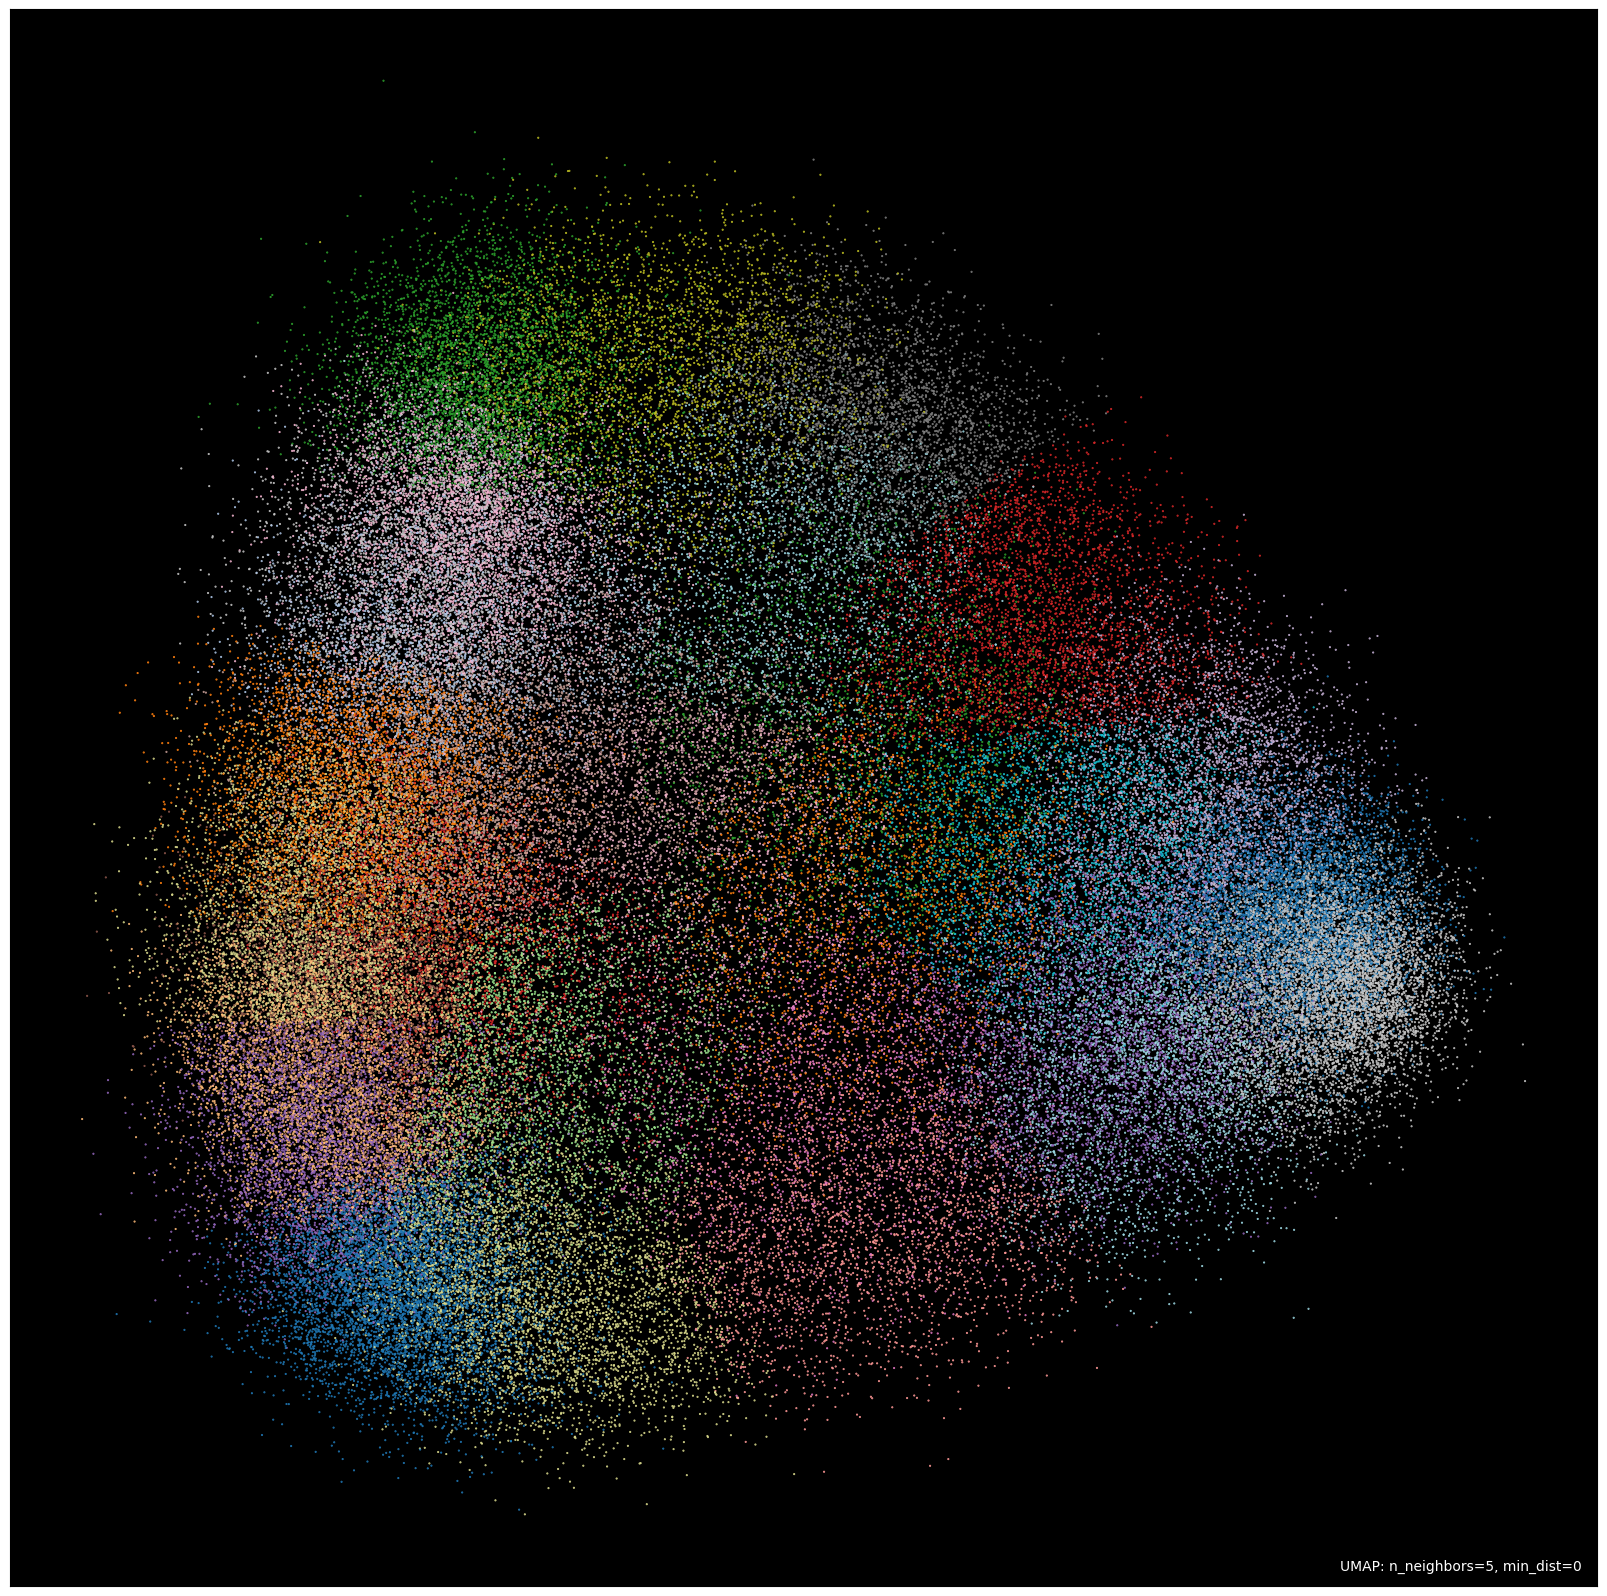

In [166]:
plot_it(res, get_colors(kmeans_res.labels_))

In [16]:
from datasets import load_dataset

In [24]:
dataset = load_dataset("mwarchalowski/grants", "full_clean_emb_mapped")

In [ ]:
get_colors(kmeans_res.labels_)

In [167]:
respd = pd.DataFrame(res, columns=('x','y'))
respd["label"] = pd.Categorical(kmeans_res.labels_)

In [168]:
all_labels = np.unique(respd['label'])
all_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [158]:
import colorcet
from datashader.colors import colormap_select, Greys9
from functools import partial


In [169]:
background = 'black'
cm = partial(colormap_select, reverse=(background!="blackz"))

In [170]:
full_map = cm(colorcet.glasbey_dark)
ckey = [full_map[i] for i,label in enumerate(all_labels)]

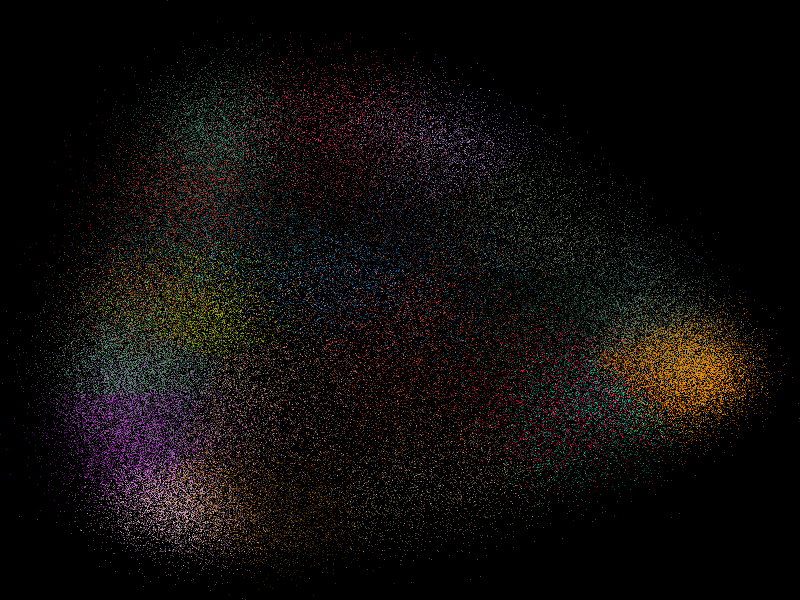

In [171]:
min_alpha = 100
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(respd, 'x', 'y', ds.count_cat('label'))
img = ds.tf.shade(agg, color_key=ckey, how='eq_hist', min_alpha=min_alpha)
# img = ds.tf.shade(agg.sel(label=[1]), color_key=cm(colorcet.glasbey_dark), how='eq_hist', min_alpha=min_alpha)
r_img = tf.set_background(img, background)
r_img

In [162]:
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)])
grays2  = grays2 + ["red"]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
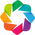

In [50]:
import holoviews as hv
from holoviews.element import tiles
from holoviews.operation.datashader import datashade, dynspread, rasterize
from holoviews import opts
hv.extension('bokeh')


In [51]:
opts.defaults(opts.Overlay(width=900, height=525, xaxis=None, yaxis=None))

In [174]:
from datashader.utils import lnglat_to_meters as webm
color_points = hv.NdOverlay({i: hv.Points(webm(-80,40)).opts(color=v, size=1) for i,v in enumerate(ckey)})
color_points.opts(clone=True, height=1024, width=135)


:NdOverlay   [Element]
   :Points   [x,y]

In [173]:
_color_key = {'w':'aqua', 'b':'lime',  'a':'red', 'h':'fuchsia', 'o':'yellow'}
races = {'w':'White', 'b':'Black', 'a':'Asian', 'h':'Hispanic', 'o':'Other'}

# color_points = hv.NdOverlay({races[k]: hv.Points([webm(-80,40)]).opts(color=v, size=0) for k, v in _color_key.items()})
# color_points = hv.NdOverlay({races[k]: hv.Points([1,1]).opts(color=v, size=0) for k, v in _color_key.items()})
color_points = hv.NdOverlay({str(k): hv.Points([10,10]).opts(color=v, size=0) for k, v in enumerate(cm(colorcet.glasbey_dark))})

color_points.opts(clone=True, height=500, width=500)


:NdOverlay   [Element]
   :Points   [x,y]

In [67]:
_color_key.items()

dict_items([('w', 'aqua'), ('b', 'lime'), ('a', 'red'), ('h', 'fuchsia'), ('o', 'yellow')])

In [108]:
[(k,v) for k,v in enumerate(cm(colorcet.glasbey_dark, .91))]

[(0, '#a57bb8'),
 (1, '#8eba00'),
 (2, '#f2007b'),
 (3, '#8e7b01'),
 (4, '#004b00'),
 (5, '#ff7752'),
 (6, '#729a7c'),
 (7, '#0774d8'),
 (8, '#790000'),
 (9, '#645472'),
 (10, '#bf03b8'),
 (11, '#bcb6ff'),
 (12, '#a17569'),
 (13, '#0000dd'),
 (14, '#15e18c'),
 (15, '#005659'),
 (16, '#573b00'),
 (17, '#6b004f'),
 (18, '#ff7ed1'),
 (19, '#e6a500'),
 (20, '#00acc6'),
 (21, '#018700'),
 (22, '#8c3bff'),
 (23, '#d60000')]